In [ ]:
# Importando bibliotecas

import pandas as pd
import numpy as np
from textblob import TextBlob
import re
import matplotlib.pyplot as plt
import seaborn as sns
import subprocess
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter


from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


import scipy
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import PolynomialFeatures, MaxAbsScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import Ridge




In [2]:
telegram = pd.read_csv('../dataset/mensagens_com_frequencia_e_texto_processado.csv')

In [4]:
telegram.columns

Index(['texto_original', 'frequencia', 'texto_limpo', 'text_processed'], dtype='object')

In [16]:
# Contar a quantidade de valores nulos na coluna 'texto_original'
nulos_count = telegram['texto_original'].isnull().sum()

# Exibir o resultado
print(f"Quantidade de valores nulos na coluna 'texto_original': {nulos_count}")


Quantidade de valores nulos na coluna 'texto_original': 0


In [17]:
# Excluir as linhas onde 'texto_original' é nula, modificando o dataframe original
telegram.dropna(subset=['texto_original'], inplace=True)

In [18]:
# Contar palavras (split por espaço)
telegram['qtd_palavras'] = telegram['texto_original'].str.split().str.len()

# Contar caracteres (inclui espaços e pontuação)
telegram['qtd_caracteres'] = telegram['texto_original'].str.len()

## Pipeline Regressão

In [19]:
# Verificar informações gerais
print(telegram.info())

<class 'pandas.core.frame.DataFrame'>
Index: 188263 entries, 0 to 188263
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   texto_original  188263 non-null  object
 1   frequencia      188263 non-null  int64 
 2   texto_limpo     188263 non-null  object
 3   text_processed  188263 non-null  object
 4   qtd_palavras    188263 non-null  int64 
 5   qtd_caracteres  188263 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 10.1+ MB
None


In [20]:
# Verificar estatísticas descritivas
print(telegram.describe())

          frequencia   qtd_palavras  qtd_caracteres
count  188263.000000  188263.000000   188263.000000
mean        1.815806      35.190569      221.518121
std        40.573635      58.324270      362.977770
min         1.000000       5.000000       12.000000
25%         1.000000      13.000000       82.000000
50%         1.000000      19.000000      124.000000
75%         1.000000      33.000000      216.000000
max     17422.000000    1261.000000     4096.000000


In [3]:
dfsp = telegram.copy()

In [101]:
dfsp.shape

(188264, 4)

In [100]:
dfsp['frequencia'].value_counts()

frequencia
1        151591
2         17230
3          6790
4          3874
5          2277
          ...  
114           1
65            1
120           1
121           1
17422         1
Name: count, Length: 140, dtype: int64

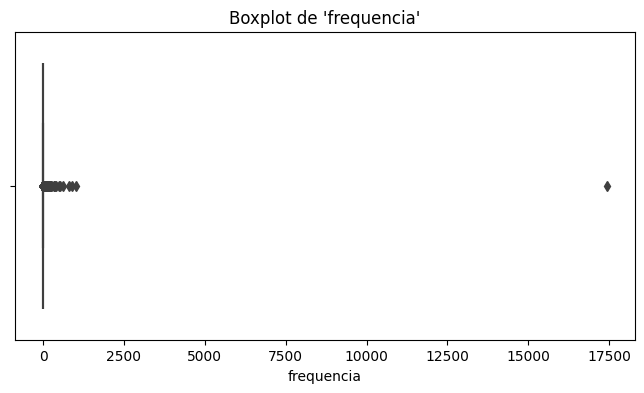

Limite inferior: 1.0
Total de outliers: 36673


In [22]:
# Boxplot para visualizar possíveis outliers em 'frequencia de mensagens'
plt.figure(figsize=(8, 4))
sns.boxplot(x=dfsp['frequencia'])
plt.title("Boxplot de 'frequencia'")
plt.show()

# Cálculo do IQR para identificar outliers
q1 = dfsp['frequencia'].quantile(0.25)
q3 = dfsp['frequencia'].quantile(0.75)
iqr = q3 - q1

limite_inferior = q1 - 1.5 * iqr
limite_superior = q3 + 1.5 * iqr

# Filtrar linhas que estão fora dos limites diretamente no dfsp_filtrado
outliers = dfsp[
    (dfsp['frequencia'] < limite_inferior) | 
    (dfsp['frequencia'] > limite_superior)
]

print("Limite inferior:", limite_inferior)

print("Total de outliers:", outliers.shape[0])

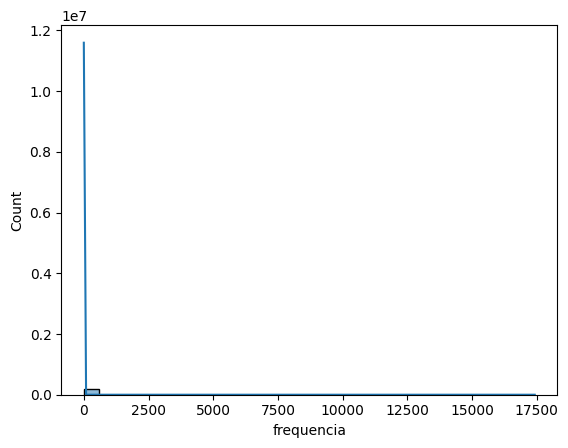

In [78]:

sns.histplot(dfsp['frequencia'], bins=30, kde=True)
plt.show()

### Preparação das Bibliotecas e execução dos modelos

In [ ]:
def evaluate_model_with_outer_cv(X_train_val, y_train_val, X_test, y_test, vectorizer, model, scaler, outer_splits=5):
    outer_cv = KFold(n_splits=outer_splits, shuffle=True, random_state=42)
    results = []

    for train_index, val_index in outer_cv.split(X_train_val):
        X_train, X_val = X_train_val.iloc[train_index], X_train_val.iloc[val_index]
        y_train, y_val = y_train_val.iloc[train_index], y_train_val.iloc[val_index]

        # Vetorização
        X_train_vec = vectorizer.fit_transform(X_train) if hasattr(vectorizer, 'fit') else vectorizer.transform(X_train)
        X_val_vec = vectorizer.transform(X_val)
        X_test_vec = vectorizer.transform(X_test)

        # Escalonamento (se necessário)
        if scaler:
            X_train_vec = scaler.fit_transform(X_train_vec)
            X_val_vec = scaler.transform(X_val_vec)
            X_test_vec = scaler.transform(X_test_vec)

        model.fit(X_train_vec, y_train)

        y_val_pred = model.predict(X_val_vec)
        y_test_pred = model.predict(X_test_vec)

        # Métricas de avaliação
        val_mse = mean_squared_error(y_val, y_val_pred)
        val_rmse = np.sqrt(val_mse)
        val_mae = mean_absolute_error(y_val, y_val_pred)
        val_r2 = r2_score(y_val, y_val_pred)

        test_mse = mean_squared_error(y_test, y_test_pred)
        test_rmse = np.sqrt(test_mse)
        test_mae = mean_absolute_error(y_test, y_test_pred)
        test_r2 = r2_score(y_test, y_test_pred)

        results.append((val_mse, val_rmse, val_mae, val_r2, test_mse, test_rmse, test_mae, test_r2))

    # Retornar médias das métricas
    return {
        'val_mse': np.mean([r[0] for r in results]),
        'val_rmse': np.mean([r[1] for r in results]),
        'val_mae': np.mean([r[2] for r in results]),
        'val_r2': np.mean([r[3] for r in results]),
        'test_mse': np.mean([r[4] for r in results]),
        'test_rmse': np.mean([r[5] for r in results]),
        'test_mae': np.mean([r[6] for r in results]),
        'test_r2': np.mean([r[7] for r in results]),
    }


In [ ]:
sentences = [text.split() for text in X_train_val]  
w2v_model = Word2Vec(sentences=sentences, vector_size=100, window=5, min_count=1, workers=4)

class Word2VecTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, w2v_model, size=100):
        self.w2v_model = w2v_model
        self.size = size
        
    def fit(self, X, y=None):
        # Não faz nada, pois já temos w2v_model pré-treinado
        return self

    def transform(self, X):
        vectors = []
        for text in X:
            words = text.split()
            word_vecs = [
                self.w2v_model.wv[w] for w in words if w in self.w2v_model.wv
            ]
            if len(word_vecs) == 0:
                # Se nenhuma palavra for conhecida, vetor zero
                vectors.append(np.zeros(self.size))
            else:
                vectors.append(np.mean(word_vecs, axis=0))
        return np.array(vectors)


In [ ]:
# Definir os vetorizadores e modelos
vectorizers = {
    'BOW Unigram': CountVectorizer(ngram_range=(1, 1)),
    'BOW Bigram': CountVectorizer(ngram_range=(1, 2)),
    'BOW Trigram': CountVectorizer(ngram_range=(1, 3)),
    'TF-IDF Unigram': TfidfVectorizer(ngram_range=(1, 1)),
    'TF-IDF Bigram': TfidfVectorizer(ngram_range=(1, 2)),
    'TF-IDF Trigram': TfidfVectorizer(ngram_range=(1, 3)),
    'Word2Vec': Word2VecTransformer(w2v_model, size=100)
}

## Regressão Linear

In [ ]:
# define X e y 
X = dfsp['texto_original']
y = dfsp['frequencia']

# Realizar o Train-Test Split para criar um conjunto de teste final
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
models = {
    'Linear Regression': LinearRegression()
}

scalers = {
    'None': None,
    'Min-Max': MaxAbsScaler()
}

In [17]:
from tqdm import tqdm
from itertools import product

results = []

# Gerar todas as combinações possíveis entre vectorizer, model e scaler
combinacoes = list(product(vectorizers.items(), models.items(), scalers.items()))

# Exibir total de combinações
print(f"Total de combinações: {len(combinacoes)}")

# Loop com barra de progresso
for (vec_name, vectorizer), (model_name, model), (scaler_name, scaler) in tqdm(combinacoes, desc="Executando combinações"):
    
    metrics = evaluate_model_with_outer_cv(
        X_train_val, y_train_val,
        X_test, y_test,
        vectorizer, model, scaler
    )
    
    results.append({
        'Vectorizer': vec_name,
        'Model': model_name,
        'Scaler': scaler_name,
        'Val MSE': metrics['val_mse'],
        'Val RMSE': metrics['val_rmse'],
        'Val MAE': metrics['val_mae'],
        'Val R²': metrics['val_r2'],
        'Test MSE': metrics['test_mse'],
        'Test RMSE': metrics['test_rmse'],
        'Test MAE': metrics['test_mae'],
        'Test R²': metrics['test_r2']
    })

# Converter resultados para DataFrame para melhor visualização
results_df = pd.DataFrame(results)

# Exibir os resultados
print(results_df)

# Salvar em CSV
results_df.to_csv('../resultados/sp_Linear_Regression_multivariada.csv', index=False)


Total de combinações: 14


Executando combinações: 100%|██████████| 14/14 [55:56:27<00:00, 14384.85s/it]   


        Vectorizer              Model   Scaler      Val MSE   Val RMSE  \
0      BOW Unigram  Linear Regression     None  7909.036885  88.255213   
1      BOW Unigram  Linear Regression  Min-Max  6079.919296  75.606033   
2       BOW Bigram  Linear Regression     None  3409.961543  52.663167   
3       BOW Bigram  Linear Regression  Min-Max  2480.793550  38.434608   
4      BOW Trigram  Linear Regression     None  2935.534777  45.564429   
5      BOW Trigram  Linear Regression  Min-Max  2265.566386  33.164870   
6   TF-IDF Unigram  Linear Regression     None  3554.101609  54.338073   
7   TF-IDF Unigram  Linear Regression  Min-Max  4254.985541  61.397085   
8    TF-IDF Bigram  Linear Regression     None  2540.569153  39.488437   
9    TF-IDF Bigram  Linear Regression  Min-Max  2606.183085  40.935186   
10  TF-IDF Trigram  Linear Regression     None  2337.533193  35.530203   
11  TF-IDF Trigram  Linear Regression  Min-Max  2374.628426  36.493996   
12        Word2Vec  Linear Regression 

In [25]:
df_filtered = dfsp[dfsp['texto_original'].str.contains(r'^[\x00-\x7F]+$', regex=True)]
df_filtered.shape

(18615, 4)

In [30]:
df_filtered = df_filtered.sort_values("frequencia", ascending=False)
linhas = df_filtered.shape[0]
porcentagem_20 = round(linhas * 0.2)
print(porcentagem_20)

3723


In [31]:
df_reduzido = df_filtered[:porcentagem_20]
df_reduzido.shape

df_reduzido.to_csv("../dataset/20_por_cento_mais_virais_telegram.csv", index=False)

In [77]:
df_reduzido['frequencia'].value_counts()

frequencia
2        1622
1         662
3         591
4         288
5         171
6          93
7          74
8          43
9          39
10         33
11         17
13         14
17          8
14          7
12          6
23          5
15          5
16          4
19          4
21          4
25          4
43          3
18          3
27          3
20          2
33          2
24          1
95          1
65          1
60          1
56          1
47          1
44          1
36          1
42          1
39          1
184         1
32          1
31          1
28          1
26          1
17422       1
Name: count, dtype: int64

In [32]:
df_reduzido.head()

,texto_original,frequencia,texto_limpo,text_processed
170485,This community was blocked in Brazil following...,17422,this community was blocked in brazil following...,this community was blocked in brazil following...
81632,Foto de Maria Teresa D Valente,184,foto de maria teresa d valente,foto maria teresa d valente
3988,ESTA FALTANDO BRASILEIROS QUE VOTOU NO BOLSONA...,95,esta faltando brasileiros que votou no bolsona...,faltando brasileiros votou bolsonaro enviar co...
1043,AO VIVO: NOVA ENQUETE OFICIAL para Presidente ...,65,ao vivo nova enquete oficial para presidente d...,vivo nova enquete oficial presidente republica...
10269,- .... .- -. -.- / -.-- --- ..- / .... . .-. -...,60,user,user


In [36]:
# Contar palavras (split por espaço)
df_reduzido['qtd_palavras'] = df_reduzido['texto_original'].str.split().str.len()

# Contar caracteres (inclui espaços e pontuação)
df_reduzido['qtd_caracteres'] = df_reduzido['texto_original'].str.len()

df_reduzido['media_palavra'] = df_reduzido['qtd_caracteres'] / df_reduzido['qtd_palavras']
df_reduzido['frequencia_relativa'] = df_reduzido['frequencia'] / df_reduzido['qtd_palavras']
df_reduzido['intensidade_texto'] = df_reduzido['qtd_palavras'] * df_reduzido['frequencia']

df_reduzido.head()


,texto_original,frequencia,texto_limpo,text_processed,qtd_palavras,qtd_caracteres,media_palavra,frequencia_relativa,intensidade_texto
170485,This community was blocked in Brazil following...,17422,this community was blocked in brazil following...,this community was blocked in brazil following...,15,96,6.400000,1161.466667,261330
81632,Foto de Maria Teresa D Valente,184,foto de maria teresa d valente,foto maria teresa d valente,6,31,5.166667,30.666667,1104
3988,ESTA FALTANDO BRASILEIROS QUE VOTOU NO BOLSONA...,95,esta faltando brasileiros que votou no bolsona...,faltando brasileiros votou bolsonaro enviar co...,48,334,6.958333,1.979167,4560
1043,AO VIVO: NOVA ENQUETE OFICIAL para Presidente ...,65,ao vivo nova enquete oficial para presidente d...,vivo nova enquete oficial presidente republica...,15,118,7.866667,4.333333,975
10269,- .... .- -. -.- / -.-- --- ..- / .... . .-. -...,60,user,user,105,360,3.428571,0.571429,6300


In [37]:
correlation = df_reduzido[['qtd_palavras', 'qtd_caracteres', 'media_palavra', 'frequencia_relativa','intensidade_texto' ,'frequencia']].corr()

correlation

,qtd_palavras,qtd_caracteres,media_palavra,frequencia_relativa,intensidade_texto,frequencia
qtd_palavras,1.000000,0.895793,-0.094870,-0.005665,0.020252,-0.001429
qtd_caracteres,0.895793,1.000000,0.167008,-0.005587,0.015479,-0.002319
media_palavra,-0.094870,0.167008,1.000000,-0.003854,-0.007091,-0.005321
frequencia_relativa,-0.005665,-0.005587,-0.003854,1.000000,0.998643,0.999723
intensidade_texto,0.020252,0.015479,-0.007091,0.998643,1.000000,0.999306
frequencia,-0.001429,-0.002319,-0.005321,0.999723,0.999306,1.000000


## Regressão Linear com Regularização Ridge (L2)

In [96]:
# define X e y 
X = df_reduzido['texto_original']
y = df_reduzido['frequencia']


# Realizar o Train-Test Split para criar um conjunto de teste final
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [97]:
models = {
    'Ridge Regression': Ridge()
}

scalers = {
    'None': None,
    'Min-Max': MaxAbsScaler()
}

In [99]:
from tqdm import tqdm
from itertools import product

results = []

# Gerar todas as combinações possíveis entre vectorizer, model e scaler
combinacoes = list(product(vectorizers.items(), models.items(), scalers.items()))

# Exibir total de combinações
print(f"Total de combinações: {len(combinacoes)}")

for (vec_name, vectorizer), (model_name, model), (scaler_name, scaler) in tqdm(combinacoes, desc="Executando combinações"):
    # Fit para obter número de features
    try:
        X_sample_vec = vectorizer.fit_transform(X_train_val[:10]) if hasattr(vectorizer, 'fit') else vectorizer.transform(X_train_val[:10])
        if hasattr(X_sample_vec, 'shape'):
            num_features = X_sample_vec.shape[1]
        elif isinstance(X_sample_vec, np.ndarray):
            num_features = X_sample_vec.shape[1]
        else:
            num_features = None
    except Exception as e:
        print(f"Erro ao calcular número de features para {vec_name}: {e}")
        num_features = None
        
    metrics = evaluate_model_with_outer_cv(
        X_train_val, y_train_val,
        X_test, y_test,
        vectorizer, model, scaler
    )

    results.append({
        'Vectorizer': vec_name,
        'Model': model_name,
        'Scaler': scaler_name,
        'Num Features': num_features,  
        'Val MSE': metrics['val_mse'],
        'Val RMSE': metrics['val_rmse'],
        'Val MAE': metrics['val_mae'],
        'Val R²': metrics['val_r2'],
        'Test MSE': metrics['test_mse'],
        'Test RMSE': metrics['test_rmse'],
        'Test MAE': metrics['test_mae'],
        'Test R²': metrics['test_r2']
    })


# Converter resultados para DataFrame para melhor visualização
results_df = pd.DataFrame(results)

# Exibir os resultados
print(results_df)

# Salvar em CSV
results_df.to_csv('sp_Ridge_Linear_Regression.csv', index=False)



Total de combinações: 14


Executando combinações:   0%|          | 0/14 [00:00<?, ?it/s]

Executando combinações: 100%|██████████| 14/14 [03:36<00:00, 15.43s/it]

        Vectorizer             Model   Scaler  Num Features    Val MSE  \
0      BOW Unigram  Ridge Regression     None           129  62.384647   
1      BOW Unigram  Ridge Regression  Min-Max           129  41.862289   
2       BOW Bigram  Ridge Regression     None           269  70.920935   
3       BOW Bigram  Ridge Regression  Min-Max           269  40.469923   
4      BOW Trigram  Ridge Regression     None           402  81.645078   
5      BOW Trigram  Ridge Regression  Min-Max           402  39.275213   
6   TF-IDF Unigram  Ridge Regression     None           129  31.109821   
7   TF-IDF Unigram  Ridge Regression  Min-Max           129  37.339736   
8    TF-IDF Bigram  Ridge Regression     None           269  31.252916   
9    TF-IDF Bigram  Ridge Regression  Min-Max           269  38.580986   
10  TF-IDF Trigram  Ridge Regression     None           402  31.491936   
11  TF-IDF Trigram  Ridge Regression  Min-Max           402  39.281491   
12        Word2Vec  Ridge Regression  

## Regressão Polinomial

In [45]:
# Definir os vetorizadores e modelos
vectorizers = {
   # 'BOW Unigram': CountVectorizer(ngram_range=(1, 1), max_features=10000),
    #'BOW Bigram': CountVectorizer(ngram_range=(1, 2), max_features=10000),
    #'BOW Trigram': CountVectorizer(ngram_range=(1, 3), max_features=10000),
    #'TF-IDF Unigram': TfidfVectorizer(ngram_range=(1, 1), max_features=10000),
    #'TF-IDF Bigram': TfidfVectorizer(ngram_range=(1, 2), max_features=10000),
    #'TF-IDF Trigram': TfidfVectorizer(ngram_range=(1, 3), max_features=10000),
    'Word2Vec': Word2VecTransformer(w2v_model, size=100)
}

In [46]:
# define X e y 
X = df_reduzido['texto_original']
y = df_reduzido['frequencia']


# Realizar o Train-Test Split para criar um conjunto de teste final
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
models = {
    'Polynomial Regression (Grau 3)': Pipeline([
        ('poly', PolynomialFeatures(degree=3, include_bias=False)),
        ('linear', LinearRegression())
    ]),
    'Polynomial + Ridge': Pipeline([
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('ridge', Ridge(alpha=1.0))
    ])
}

scalers = {
    'None': None,
    'Min-Max': MaxAbsScaler()
}

In [49]:
from tqdm import tqdm
from itertools import product

results = []

# Gerar todas as combinações possíveis entre vectorizer, model e scaler
combinacoes = list(product(vectorizers.items(), models.items(), scalers.items()))

# Exibir total de combinações
print(f"Total de combinações: {len(combinacoes)}")

# Loop com barra de progresso
for (vec_name, vectorizer), (model_name, model), (scaler_name, scaler) in tqdm(combinacoes, desc="Executando combinações"):
    
    metrics = evaluate_model_with_outer_cv(
        X_train_val, y_train_val,
        X_test, y_test,
        vectorizer, model, scaler
    )
    
    results.append({
        'Vectorizer': vec_name,
        'Model': model_name,
        'Scaler': scaler_name,
        'Val MSE': metrics['val_mse'],
        'Val RMSE': metrics['val_rmse'],
        'Val MAE': metrics['val_mae'],
        'Val R²': metrics['val_r2'],
        'Test MSE': metrics['test_mse'],
        'Test RMSE': metrics['test_rmse'],
        'Test MAE': metrics['test_mae'],
        'Test R²': metrics['test_r2']
    })

# Converter resultados para DataFrame para melhor visualização
results_df = pd.DataFrame(results)

# Exibir os resultados
print(results_df)

# Salvar em CSV
results_df.to_csv('sp_Polinomial_Regression.csv', index=False)



Total de combinações: 4


Executando combinações: 100%|██████████| 4/4 [1:40:09<00:00, 1502.31s/it]  


  Vectorizer                           Model   Scaler     Val MSE   Val RMSE  \
0   Word2Vec  Polynomial Regression (Grau 2)     None   29.062652   5.109017   
1   Word2Vec  Polynomial Regression (Grau 2)  Min-Max   29.079751   5.115096   
2   Word2Vec              Polynomial + Ridge     None  111.275691  10.517818   
3   Word2Vec              Polynomial + Ridge  Min-Max   34.452604   5.656618   

    Val MAE    Val R²      Test MSE   Test RMSE   Test MAE   Test R²  
0  2.043210 -0.016725  407271.13125  638.177978  25.339501 -0.001331  
1  2.054571 -0.021046  407265.27500  638.173389  25.365436 -0.001316  
2  6.033287 -4.542933  407328.28125  638.222751  29.363953 -0.001471  
3  2.607033 -0.301770  407287.84375  638.191071  25.746707 -0.001372  


## Pré-processamento de dados

In [50]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from unidecode import unidecode


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

stop_words = set(stopwords.words('portuguese'))

custom_stopwords = {'.', 'oi','vc', 'pq', 'tá', 'blz', 'kkk', 'né', 'eh', 'tipo'}

stop_words.update(custom_stopwords)


def preprocess_text(text):

    # Função para extrair e substituir o domínio da URL
    def substituir_dominios(texto):
        # Função para extrair e substituir o domínio da URL
        def extrair_dominio(url):
            # Remove o protocolo (http://, https://, etc.) e o "www." se presente
            dominio = re.sub(r'^https?://(?:www\.)?|www\.', '', url)
            # Remove o caminho e parâmetros da URL
            dominio = re.split(r'[/?#]', dominio)[0]
            # Retorna a parte principal do domínio (antes do primeiro ponto)
            return dominio.split('.')[0]

        # Substitui URLs por seus domínios principais
        return re.sub(r'https?://(?:www\.)?\S+|www\.\S+', lambda match: extrair_dominio(match.group(0)), texto)
    
    # Substituir domínios
    text = substituir_dominios(text)
    
    # Converte para minúsculas
    text = text.lower()

    # Remove acentos
    text = unidecode(text)

    #Remover Pontuação
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove URLs e menções
    #text = re.sub(r'http\S+|www\S+|https\S+|@\w+', '', text)

    # Substitui emojis repetidos por apenas um
    text = re.sub(r'([\U00010000-\U0010FFFF])\1+', r'\1', text)
    text = re.sub(r'([\U0001F600-\U0001F64F]|[\U0001F300-\U0001F5FF]|[\U0001F680-\U0001F6FF]|[\U0001F700-\U0001F77F]|[\U0001F780-\U0001F7FF]|[\U0001F800-\U0001F8FF]|[\U0001F900-\U0001F9FF]|[\U0001FA00-\U0001FA6F]|[\U0001FA70-\U0001FAFF])\1+', r'\1', text)


    # Remove espaços em branco extras (início ou final) e múltiplos espaços no meio do texto
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove pontuações e caracteres especiais
    #text = re.sub(r'[^\w\s]', '', text)

    # Ajusta risadas "kkk" ou mais para "kk"
    text = re.sub(r'k{2,}|K{2,}', 'kk', text)

    # Ajusta risadas "haha" ou mais para "haha"
    text = re.sub(r'(ha){2,}', 'haha', text, flags=re.IGNORECASE)

    # Ajusta risadas "kaka" ou mais para "kaka"
    text = re.sub(r'(ka){2,}', 'kaka', text, flags=re.IGNORECASE)

    # Remove as stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
       

    return text

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Criando nova cópia do DataFrame
dfcp_filtrado = df_reduzido.copy()

# Aplicando pré-processamento à coluna de texto
dfcp_filtrado['text_processed'] = dfcp_filtrado['texto_original'].apply(preprocess_text)


In [53]:
dfcp_filtrado

,texto_original,frequencia,texto_limpo,text_processed,qtd_palavras,qtd_caracteres,media_palavra,frequencia_relativa,intensidade_texto
170485,This community was blocked in Brazil following...,17422,this community was blocked in brazil following...,this community was blocked in brazil following...,15,96,6.400000,1161.466667,261330
81632,Foto de Maria Teresa D Valente,184,foto de maria teresa d valente,foto maria teresa d valente,6,31,5.166667,30.666667,1104
3988,ESTA FALTANDO BRASILEIROS QUE VOTOU NO BOLSONA...,95,esta faltando brasileiros que votou no bolsona...,faltando brasileiros votou bolsonaro enviar co...,48,334,6.958333,1.979167,4560
1043,AO VIVO: NOVA ENQUETE OFICIAL para Presidente ...,65,ao vivo nova enquete oficial para presidente d...,vivo nova enquete oficial presidente republica...,15,118,7.866667,4.333333,975
10269,- .... .- -. -.- / -.-- --- ..- / .... . .-. -...,60,user,user,105,360,3.428571,0.571429,6300
...,...,...,...,...,...,...,...,...,...
21033,Acabei de receber minha chance e estou muito e...,1,acabei de receber minha chance e estou muito e...,acabei receber chance empolgado novo gerente m...,14,81,5.785714,0.071429,14
21437,Achei q o Bolsonaro ta meio perdido... nao foi...,1,achei q o bolsonaro ta meio perdido nao foi be...,achei q bolsonaro ta meio perdido nao bem asse...,14,78,5.571429,0.071429,14
21415,Achei jogado nem frente a escola da minha filha.,1,achei jogado nem frente a escola da minha filha,achei jogado frente escola filha,9,48,5.333333,0.111111,9
21427,Achei o debate bem tranquilo... e o ladrao sem...,1,achei o debate bem tranquilo e o ladrao sempre...,achei debate bem tranquilo ladrao sempre pingu...,12,68,5.666667,0.083333,12


In [ ]:
# define X e y 
X = dfcp_filtrado['text_processed']
y = dfcp_filtrado['frequencia']


# Realizar o Train-Test Split para criar um conjunto de teste final
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [55]:
sentences = [text.split() for text in X_train_val]  
w2v_model = Word2Vec(sentences=sentences, vector_size=100, window=5, min_count=1, workers=4)

class Word2VecTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, w2v_model, size=100):
        self.w2v_model = w2v_model
        self.size = size
        
    def fit(self, X, y=None):
        # Não faz nada, pois já temos w2v_model pré-treinado
        return self

    def transform(self, X):
        vectors = []
        for text in X:
            words = text.split()
            word_vecs = [
                self.w2v_model.wv[w] for w in words if w in self.w2v_model.wv
            ]
            if len(word_vecs) == 0:
                # Se nenhuma palavra for conhecida, vetor zero
                vectors.append(np.zeros(self.size))
            else:
                vectors.append(np.mean(word_vecs, axis=0))
        return np.array(vectors)


In [ ]:
def evaluate_model_with_outer_cv(X_train_val, y_train_val, X_test, y_test, vectorizer, model, scaler, outer_splits=5):
    outer_cv = KFold(n_splits=outer_splits, shuffle=True, random_state=42)
    results = []

    for train_index, val_index in outer_cv.split(X_train_val):
        X_train, X_val = X_train_val.iloc[train_index], X_train_val.iloc[val_index]
        y_train, y_val = y_train_val.iloc[train_index], y_train_val.iloc[val_index]

        # Vetorização
        X_train_vec = vectorizer.fit_transform(X_train) if hasattr(vectorizer, 'fit') else vectorizer.transform(X_train)
        X_val_vec = vectorizer.transform(X_val)
        X_test_vec = vectorizer.transform(X_test)

    

        # Escalonamento (se necessário)
        if scaler:
            X_train_vec = scaler.fit_transform(X_train_vec)
            X_val_vec = scaler.transform(X_val_vec)
            X_test_vec = scaler.transform(X_test_vec)

        model.fit(X_train_vec, y_train)

        y_val_pred = model.predict(X_val_vec)
        y_test_pred = model.predict(X_test_vec)

        # Métricas de avaliação
        val_mse = mean_squared_error(y_val, y_val_pred)
        val_rmse = np.sqrt(val_mse)
        val_mae = mean_absolute_error(y_val, y_val_pred)
        val_r2 = r2_score(y_val, y_val_pred)

        test_mse = mean_squared_error(y_test, y_test_pred)
        test_rmse = np.sqrt(test_mse)
        test_mae = mean_absolute_error(y_test, y_test_pred)
        test_r2 = r2_score(y_test, y_test_pred)

        results.append((val_mse, val_rmse, val_mae, val_r2, test_mse, test_rmse, test_mae, test_r2))

    # Retornar médias das métricas
    return {
        'val_mse': np.mean([r[0] for r in results]),
        'val_rmse': np.mean([r[1] for r in results]),
        'val_mae': np.mean([r[2] for r in results]),
        'val_r2': np.mean([r[3] for r in results]),
        'test_mse': np.mean([r[4] for r in results]),
        'test_rmse': np.mean([r[5] for r in results]),
        'test_mae': np.mean([r[6] for r in results]),
        'test_r2': np.mean([r[7] for r in results]),
    }


## Regressão Linear

In [92]:
models = {
    'Linear Regression': LinearRegression(),
    
}

scalers = {
    'None': None,
    'Min-Max': MaxAbsScaler()
}

In [93]:
# Definir os vetorizadores e modelos
vectorizers = {
    'BOW Unigram': CountVectorizer(ngram_range=(1, 1)),
    'BOW Bigram': CountVectorizer(ngram_range=(1, 2)),
    'BOW Trigram': CountVectorizer(ngram_range=(1, 3)),
    'TF-IDF Unigram': TfidfVectorizer(ngram_range=(1, 1)),
    'TF-IDF Bigram': TfidfVectorizer(ngram_range=(1, 2)),
    'TF-IDF Trigram': TfidfVectorizer(ngram_range=(1, 3)),
    'Word2Vec': Word2VecTransformer(w2v_model, size=100)
}

In [95]:
from tqdm import tqdm
from itertools import product

results = []

# Gerar todas as combinações possíveis entre vectorizer, model e scaler
combinacoes = list(product(vectorizers.items(), models.items(), scalers.items()))

# Exibir total de combinações
print(f"Total de combinações: {len(combinacoes)}")

for (vec_name, vectorizer), (model_name, model), (scaler_name, scaler) in tqdm(combinacoes, desc="Executando combinações"):
    # Fit para obter número de features
    try:
        X_sample_vec = vectorizer.fit_transform(X_train_val[:10]) if hasattr(vectorizer, 'fit') else vectorizer.transform(X_train_val[:10])
        if hasattr(X_sample_vec, 'shape'):
            num_features = X_sample_vec.shape[1]
        elif isinstance(X_sample_vec, np.ndarray):
            num_features = X_sample_vec.shape[1]
        else:
            num_features = None
    except Exception as e:
        print(f"Erro ao calcular número de features para {vec_name}: {e}")
        num_features = None
        
    metrics = evaluate_model_with_outer_cv(
        X_train_val, y_train_val,
        X_test, y_test,
        vectorizer, model, scaler
    )

    results.append({
        'Vectorizer': vec_name,
        'Model': model_name,
        'Scaler': scaler_name,
        'Num Features': num_features,  
        'Val MSE': metrics['val_mse'],
        'Val RMSE': metrics['val_rmse'],
        'Val MAE': metrics['val_mae'],
        'Val R²': metrics['val_r2'],
        'Test MSE': metrics['test_mse'],
        'Test RMSE': metrics['test_rmse'],
        'Test MAE': metrics['test_mae'],
        'Test R²': metrics['test_r2']
    })


# Converter resultados para DataFrame para melhor visualização
results_df = pd.DataFrame(results)

# Exibir os resultados
print(results_df)

# Salvar em CSV
results_df.to_csv('cp_Linear_Regression.csv', index=False)



Total de combinações: 14


Executando combinações: 100%|██████████| 14/14 [04:08<00:00, 17.76s/it]

        Vectorizer              Model   Scaler  Num Features      Val MSE  \
0      BOW Unigram  Linear Regression     None           112  5319.524205   
1      BOW Unigram  Linear Regression  Min-Max           112  5548.397096   
2       BOW Bigram  Linear Regression     None           227   186.232966   
3       BOW Bigram  Linear Regression  Min-Max           227   688.364663   
4      BOW Trigram  Linear Regression     None           333   192.308054   
5      BOW Trigram  Linear Regression  Min-Max           333   520.277552   
6   TF-IDF Unigram  Linear Regression     None           112   142.377400   
7   TF-IDF Unigram  Linear Regression  Min-Max           112   137.058706   
8    TF-IDF Bigram  Linear Regression     None           227    46.130106   
9    TF-IDF Bigram  Linear Regression  Min-Max           227    47.690927   
10  TF-IDF Trigram  Linear Regression     None           333    46.144420   
11  TF-IDF Trigram  Linear Regression  Min-Max           333    47.468662   

## Regressão Linear com Regularização Lasso (L1)

In [ ]:
models = {
    'Lasso Regression': Lasso()
}

scalers = {
    'None': None,
    'Min-Max': MaxAbsScaler()
}

In [61]:
from tqdm import tqdm
from itertools import product

results = []

# Gerar todas as combinações possíveis entre vectorizer, model e scaler
combinacoes = list(product(vectorizers.items(), models.items(), scalers.items()))

# Exibir total de combinações
print(f"Total de combinações: {len(combinacoes)}")

# Loop com barra de progresso
for (vec_name, vectorizer), (model_name, model), (scaler_name, scaler) in tqdm(combinacoes, desc="Executando combinações"):
    
    metrics = evaluate_model_with_outer_cv(
        X_train_val, y_train_val,
        X_test, y_test,
        vectorizer, model, scaler
    )
    
    results.append({
        'Vectorizer': vec_name,
        'Model': model_name,
        'Scaler': scaler_name,
        'Val MSE': metrics['val_mse'],
        'Val RMSE': metrics['val_rmse'],
        'Val MAE': metrics['val_mae'],
        'Val R²': metrics['val_r2'],
        'Test MSE': metrics['test_mse'],
        'Test RMSE': metrics['test_rmse'],
        'Test MAE': metrics['test_mae'],
        'Test R²': metrics['test_r2']
    })

# Converter resultados para DataFrame para melhor visualização
results_df = pd.DataFrame(results)

# Exibir os resultados
print(results_df)

# Salvar em CSV
results_df.to_csv('cp_Lasso_Regression.csv', index=False)



Total de combinações: 14


Executando combinações: 100%|██████████| 14/14 [01:19<00:00,  5.70s/it]


        Vectorizer             Model   Scaler    Val MSE  Val RMSE   Val MAE  \
0      BOW Unigram  Lasso Regression     None  28.985705  5.088548  1.991687   
1      BOW Unigram  Lasso Regression  Min-Max  28.985705  5.088548  1.991687   
2       BOW Bigram  Lasso Regression     None  28.985705  5.088548  1.991687   
3       BOW Bigram  Lasso Regression  Min-Max  28.985705  5.088548  1.991687   
4      BOW Trigram  Lasso Regression     None  28.985705  5.088548  1.991687   
5      BOW Trigram  Lasso Regression  Min-Max  28.985705  5.088548  1.991687   
6   TF-IDF Unigram  Lasso Regression     None  28.985705  5.088548  1.991687   
7   TF-IDF Unigram  Lasso Regression  Min-Max  28.985705  5.088548  1.991687   
8    TF-IDF Bigram  Lasso Regression     None  28.985705  5.088548  1.991687   
9    TF-IDF Bigram  Lasso Regression  Min-Max  28.985705  5.088548  1.991687   
10  TF-IDF Trigram  Lasso Regression     None  28.985705  5.088548  1.991687   
11  TF-IDF Trigram  Lasso Regression  Mi

## Regressão Polinomial

In [ ]:
models = {
    'Polynomial Regression (Grau 3)': Pipeline([
        ('poly', PolynomialFeatures(degree=3, include_bias=False)),
        ('linear', LinearRegression())
    ]),
    'Polynomial + Ridge': Pipeline([
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('ridge', Ridge(alpha=1.0))
    ])
}

scalers = {
    'None': None,
    'Min-Max': MaxAbsScaler()
}

In [63]:
vectorizers = {
    'BOW Unigram': CountVectorizer(ngram_range=(1, 1), max_features=100),
    'BOW Bigram': CountVectorizer(ngram_range=(1, 2), max_features=100),
    'BOW Trigram': CountVectorizer(ngram_range=(1, 3), max_features=100),
    'TF-IDF Unigram': TfidfVectorizer(ngram_range=(1, 1), max_features=100),
    'TF-IDF Bigram': TfidfVectorizer(ngram_range=(1, 2), max_features=100),
    'TF-IDF Trigram': TfidfVectorizer(ngram_range=(1, 3), max_features=100),
    'Word2Vec': Word2VecTransformer(w2v_model, size=100)
}


In [64]:
from tqdm import tqdm
from itertools import product

results = []

# Gerar todas as combinações possíveis entre vectorizer, model e scaler
combinacoes = list(product(vectorizers.items(), models.items(), scalers.items()))

# Exibir total de combinações
print(f"Total de combinações: {len(combinacoes)}")

# Loop com barra de progresso
for (vec_name, vectorizer), (model_name, model), (scaler_name, scaler) in tqdm(combinacoes, desc="Executando combinações"):
    
    metrics = evaluate_model_with_outer_cv(
        X_train_val, y_train_val,
        X_test, y_test,
        vectorizer, model, scaler
    )
    
    results.append({
        'Vectorizer': vec_name,
        'Model': model_name,
        'Scaler': scaler_name,
        'Val MSE': metrics['val_mse'],
        'Val RMSE': metrics['val_rmse'],
        'Val MAE': metrics['val_mae'],
        'Val R²': metrics['val_r2'],
        'Test MSE': metrics['test_mse'],
        'Test RMSE': metrics['test_rmse'],
        'Test MAE': metrics['test_mae'],
        'Test R²': metrics['test_r2']
    })

# Converter resultados para DataFrame para melhor visualização
results_df = pd.DataFrame(results)

# Exibir os resultados
print(results_df)

# Salvar em CSV
results_df.to_csv('cp_Polinomial_Regression.csv', index=False)



Total de combinações: 28


Executando combinações: 100%|██████████| 28/28 [4:01:18<00:00, 517.07s/it]   


        Vectorizer                           Model   Scaler       Val MSE  \
0      BOW Unigram  Polynomial Regression (Grau 2)     None  3.226565e+04   
1      BOW Unigram  Polynomial Regression (Grau 2)  Min-Max  3.405137e+09   
2      BOW Unigram              Polynomial + Ridge     None  1.486590e+05   
3      BOW Unigram              Polynomial + Ridge  Min-Max  2.299792e+04   
4       BOW Bigram  Polynomial Regression (Grau 2)     None  3.073270e+04   
5       BOW Bigram  Polynomial Regression (Grau 2)  Min-Max  4.184923e+09   
6       BOW Bigram              Polynomial + Ridge     None  6.268437e+05   
7       BOW Bigram              Polynomial + Ridge  Min-Max  2.559888e+04   
8      BOW Trigram  Polynomial Regression (Grau 2)     None  1.065128e+04   
9      BOW Trigram  Polynomial Regression (Grau 2)  Min-Max  1.432764e+11   
10     BOW Trigram              Polynomial + Ridge     None  5.484901e+05   
11     BOW Trigram              Polynomial + Ridge  Min-Max  3.070780e+04   